In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

## 1. Load the Dataset

In [26]:
# Load the dataset
file_path = "C:/Users/Eleanor Huang/Desktop/MLDS/Practicum/Dataset01.csv"  
df = pd.read_csv(file_path)

In [13]:
df.dtypes

MaskID          object
TypeID          object
Date            object
Step00Var1     float64
Step00Var2     float64
                ...   
Step04Var8      object
Step04Var9      object
Step04Var10     object
Step04Var12    float64
TargetVar      float64
Length: 64, dtype: object

## Data Preprocessing

### Deal with categorical Data: dummy transformation

In [27]:
# Define columns to process (all object columns except MaskID and TypeID)
excluded_cols = ['MaskID', 'TypeID', 'Date']  # Columns you don't want to encode
columns_to_process = [col for col in df.select_dtypes(include=['object']).columns if col not in excluded_cols]

numerical_like_cols = []
categorical_cols = []

# Dictionary to fix any known misspellings in categorical columns
category_mappings = {
    'Step04Var4': {
        'Greater than a DIme': 'Greater than a Dime',  # Correct typo
        'Less than a Dime': 'Less than a Dime',
        'Both (if multiple clumps)': 'Both (if multiple clumps)'
    }
}

# Apply mappings to fix categorical column values
for col, mapping in category_mappings.items():
    if col in df.columns:
        df[col] = df[col].replace(mapping)

# Process each column
for col in columns_to_process:
    unique_vals = df[col].dropna().unique()
    if len(unique_vals) > 20:  # Large number of unique values, likely numerical-like
        try:
            # Convert to numeric, replacing "Not Reported" or similar with NaN
            df[col] = pd.to_numeric(df[col].replace(['Not Reported'], np.nan), errors='coerce')
            numerical_like_cols.append(col)
        except ValueError:
            # If conversion fails, treat as categorical
            categorical_cols.append(col)
    else:
        categorical_cols.append(col)  # Treat as categorical if unique values are small

# Handle one-hot encoding for categorical columns
if categorical_cols:
    print(f"One-hot encoding the following categorical columns: {categorical_cols}")
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Final summary
df.columns

One-hot encoding the following categorical columns: ['Step01Var11', 'Step03Var2', 'Step03Var3', 'Step03Var4', 'Step03Var5', 'Step03Var9', 'Step03Var10', 'Step03Var11', 'Step03Var12', 'Step04Var2', 'Step04Var3', 'Step04Var4', 'Step04Var6', 'Step04Var7', 'Step04Var8', 'Step04Var9', 'Step04Var10']


Index(['MaskID', 'TypeID', 'Date', 'Step00Var1', 'Step00Var2', 'Step00Var3',
       'Step00Var4', 'Step00Var5', 'Step00Var6', 'Step00Var7', 'Step00Var8',
       'Step00Var9', 'Step00Var10', 'Step00Var11', 'Step00Var12',
       'Step00Var13', 'Step00Var14', 'Step00Var15', 'Step01Var1', 'Step01Var2',
       'Step01Var3', 'Step01Var4', 'Step01Var5', 'Step01Var6', 'Step01Var7',
       'Step01Var8', 'Step01Var9', 'Step01Var10', 'Step01Var12', 'Step01Var13',
       'Step01Var14', 'Step01Var15', 'Step01Var16', 'Step02Var1', 'Step02Var2',
       'Step02Var3', 'Step02Var4', 'Step02Var5', 'Step02Var6', 'Step03Var1',
       'Step03Var6', 'Step03Var7', 'Step03Var8', 'Step04Var1', 'Step04Var5',
       'Step04Var12', 'TargetVar', 'Step01Var11_1', 'Step01Var11_2',
       'Step01Var11_3', 'Step01Var11_4', 'Step01Var11_6', 'Step01Var11_7',
       'Step01Var11_Not Reported', 'Step03Var2_Yes', 'Step03Var3_2-3',
       'Step03Var3_4+', 'Step03Var4_Greater than a DIme',
       'Step03Var4_Less than a Dime'

In [29]:
# Select out numerical and categorical variables
num_vars = df.select_dtypes(include=[np.float64])
num_vars.columns

Index(['Step00Var1', 'Step00Var2', 'Step00Var3', 'Step00Var4', 'Step00Var5',
       'Step00Var6', 'Step00Var7', 'Step00Var8', 'Step00Var9', 'Step00Var10',
       'Step00Var11', 'Step00Var12', 'Step00Var13', 'Step00Var14',
       'Step00Var15', 'Step01Var1', 'Step01Var2', 'Step01Var3', 'Step01Var4',
       'Step01Var5', 'Step01Var6', 'Step01Var7', 'Step01Var8', 'Step01Var9',
       'Step01Var10', 'Step01Var12', 'Step01Var13', 'Step01Var14',
       'Step01Var15', 'Step01Var16', 'Step02Var1', 'Step02Var2', 'Step02Var3',
       'Step02Var4', 'Step02Var5', 'Step02Var6', 'Step03Var1', 'Step03Var6',
       'Step03Var7', 'Step03Var8', 'Step04Var1', 'Step04Var5', 'Step04Var12',
       'TargetVar'],
      dtype='object')

In [ ]:
# Select out encoded categorical variables
cat_vars = df.select_dtypes(include=[bool])
cat_vars = cat_vars.astype(int) # transform bool values into 0/1 dummies
cat_vars.columns
cat_vars.head()

,Step01Var11_1,Step01Var11_2,Step01Var11_3,Step01Var11_4,Step01Var11_6,Step01Var11_7,Step01Var11_Not Reported,Step03Var2_Yes,Step03Var3_2-3,Step03Var3_4+,...,Step04Var7_2-3,Step04Var7_4+,Step04Var7_Clumps dissipated,Step04Var8_Greater than a DIme,Step04Var8_Less than a Dime,Step04Var9_No Effect,Step04Var9_Some Effect,Step04Var10_2-3,Step04Var10_4+,Step04Var10_Clumps dissipated
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,1,0,1,0,0


### Deal with null values: MICE imputation method

set seed, randomly mask 10% values to do train-test split  
standardize 90% after train-test split, then run mice, impute and reverse transform the imputed values  
compute mse & accuracy on 5-fold cross validation  

In [38]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score
from fancyimpute import IterativeImputer
import numpy as np
import pandas as pd

# Function to perform imputation on numerical and categorical columns
def impute_data(num_vars, cat_vars, data):
    # Normalize numerical variables
    scaler = StandardScaler()
    data[num_vars.columns] = scaler.fit_transform(data[num_vars.columns])

    # Impute numerical variables
    num_imputer = IterativeImputer(max_iter=10, random_state=42)
    imputed_num = pd.DataFrame(
        num_imputer.fit_transform(data[num_vars.columns]),
        columns=num_vars.columns,
        index=data.index
    )

    # Reverse transform numerical variables
    imputed_num = pd.DataFrame(
        scaler.inverse_transform(imputed_num),
        columns=num_vars.columns,
        index=imputed_num.index
    )

    # Impute categorical variables
    cat_imputer = IterativeImputer(max_iter=10, random_state=42, sample_posterior=True)
    imputed_cat = pd.DataFrame(
        cat_imputer.fit_transform(data[cat_vars.columns]),
        columns=cat_vars.columns,
        index=data.index
    )

    # Post-process categorical variables to ensure binary values
    for col in cat_vars.columns:
        imputed_cat[col] = (imputed_cat[col] >= 0.5).astype(int)

    # Combine imputed numerical and categorical columns
    imputed_data = pd.concat([imputed_num, imputed_cat], axis=1)

    return imputed_data

# Function to evaluate MICE using 5-fold CV
def evaluate_imputation(original_data, num_vars, cat_vars, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    mse_scores = []
    accuracy_scores = []

    for train_index, test_index in kf.split(original_data):
        # Split the data
        train_data = original_data.iloc[train_index]
        test_data = original_data.iloc[test_index]

        # Mask 10% of training data for evaluation
        train_indices = train_data.index
        mask = train_indices[np.random.choice(
            len(train_indices), size=int(0.1 * len(train_indices)), replace=False
        )]
        masked_train_data = train_data.copy()
        masked_train_data.loc[mask] = np.nan

        # Impute masked training data
        imputed_train_data = impute_data(num_vars, cat_vars, masked_train_data)

        # Evaluate numerical imputation (MSE)
        original_num_values = train_data.loc[mask, num_vars.columns]
        imputed_num_values = imputed_train_data.loc[mask, num_vars.columns]
        valid_indices = original_num_values.dropna().index.intersection(imputed_num_values.dropna().index)
        original_num_values = original_num_values.loc[valid_indices]
        imputed_num_values = imputed_num_values.loc[valid_indices]
        mse = mean_squared_error(original_num_values, imputed_num_values)
        mse_scores.append(mse)

        # Evaluate categorical imputation (Accuracy)
        original_cat_values = train_data.loc[mask, cat_vars.columns]
        imputed_cat_values = imputed_train_data.loc[mask, cat_vars.columns]
        valid_indices = original_cat_values.dropna().index.intersection(imputed_cat_values.dropna().index)
        original_cat_values = original_cat_values.loc[valid_indices]
        imputed_cat_values = imputed_cat_values.loc[valid_indices]
        accuracy = accuracy_score(
            original_cat_values.values.flatten(),
            imputed_cat_values.values.flatten()
        )
        accuracy_scores.append(accuracy)

    print(f"Mean MSE across folds for numerical variables: {np.mean(mse_scores)}")
    print(f"Mean Accuracy across folds for categorical variables: {np.mean(accuracy_scores)}")
    return np.mean(mse_scores), np.mean(accuracy_scores)

# Main Workflow
# Assuming `num_vars` and `cat_vars` are predefined
combined_vars = pd.concat([num_vars, cat_vars], axis=1)
original_data = combined_vars.copy()

# Evaluate imputation performance using 5-fold CV
mse, accuracy = evaluate_imputation(original_data, num_vars, cat_vars)

# Final Imputation for Entire Dataset (No Masking)
final_imputed_data = impute_data(num_vars, cat_vars, original_data)

# Display Final Imputed Dataset
print("Final Imputed Dataset (First 5 Rows):")
print(final_imputed_data.head())

d:\Program Files\Anaconda\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
d:\Program Files\Anaconda\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
d:\Program Files\Anaconda\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
d:\Program Files\Anaconda\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
d:\Program Files\Anaconda\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Mean MSE across folds for numerical variables: 1.2780646241592806e+16
Mean Accuracy across folds for categorical variables: 0.869535519125683


d:\Program Files\Anaconda\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Final Imputed Dataset (First 5 Rows):
   Step00Var1  Step00Var2  Step00Var3  Step00Var4  Step00Var5  Step00Var6  \
0        12.0  32400000.0        97.6        66.8         4.0         4.0   
1        11.0  52200000.0        93.7        65.4         4.0         4.0   
2        12.0  44700000.0        94.2        65.5         4.0         4.0   
3        16.0  58600000.0        96.9        61.7         3.8         3.8   
4        14.0  74100000.0        99.1        64.4         4.0         4.0   

   Step00Var7    Step00Var8  Step00Var9  Step00Var10  ...  Step04Var7_2-3  \
0         6.0  2.236000e+09        51.0         45.0  ...               0   
1         6.1  3.497000e+09        38.0         59.0  ...               0   
2         6.1  3.040000e+09        17.0         81.0  ...               0   
3         6.2  3.750000e+09        27.0         71.0  ...               0   
4         6.2  4.891000e+09        16.0         83.0  ...               0   

   Step04Var7_4+  Step04Var7_Clumps 

## Initial Correlation Analysis   
A few features have significant correlation with the target variable, and some features have severe multicollinearity with each other

### The Imputed Correlation 

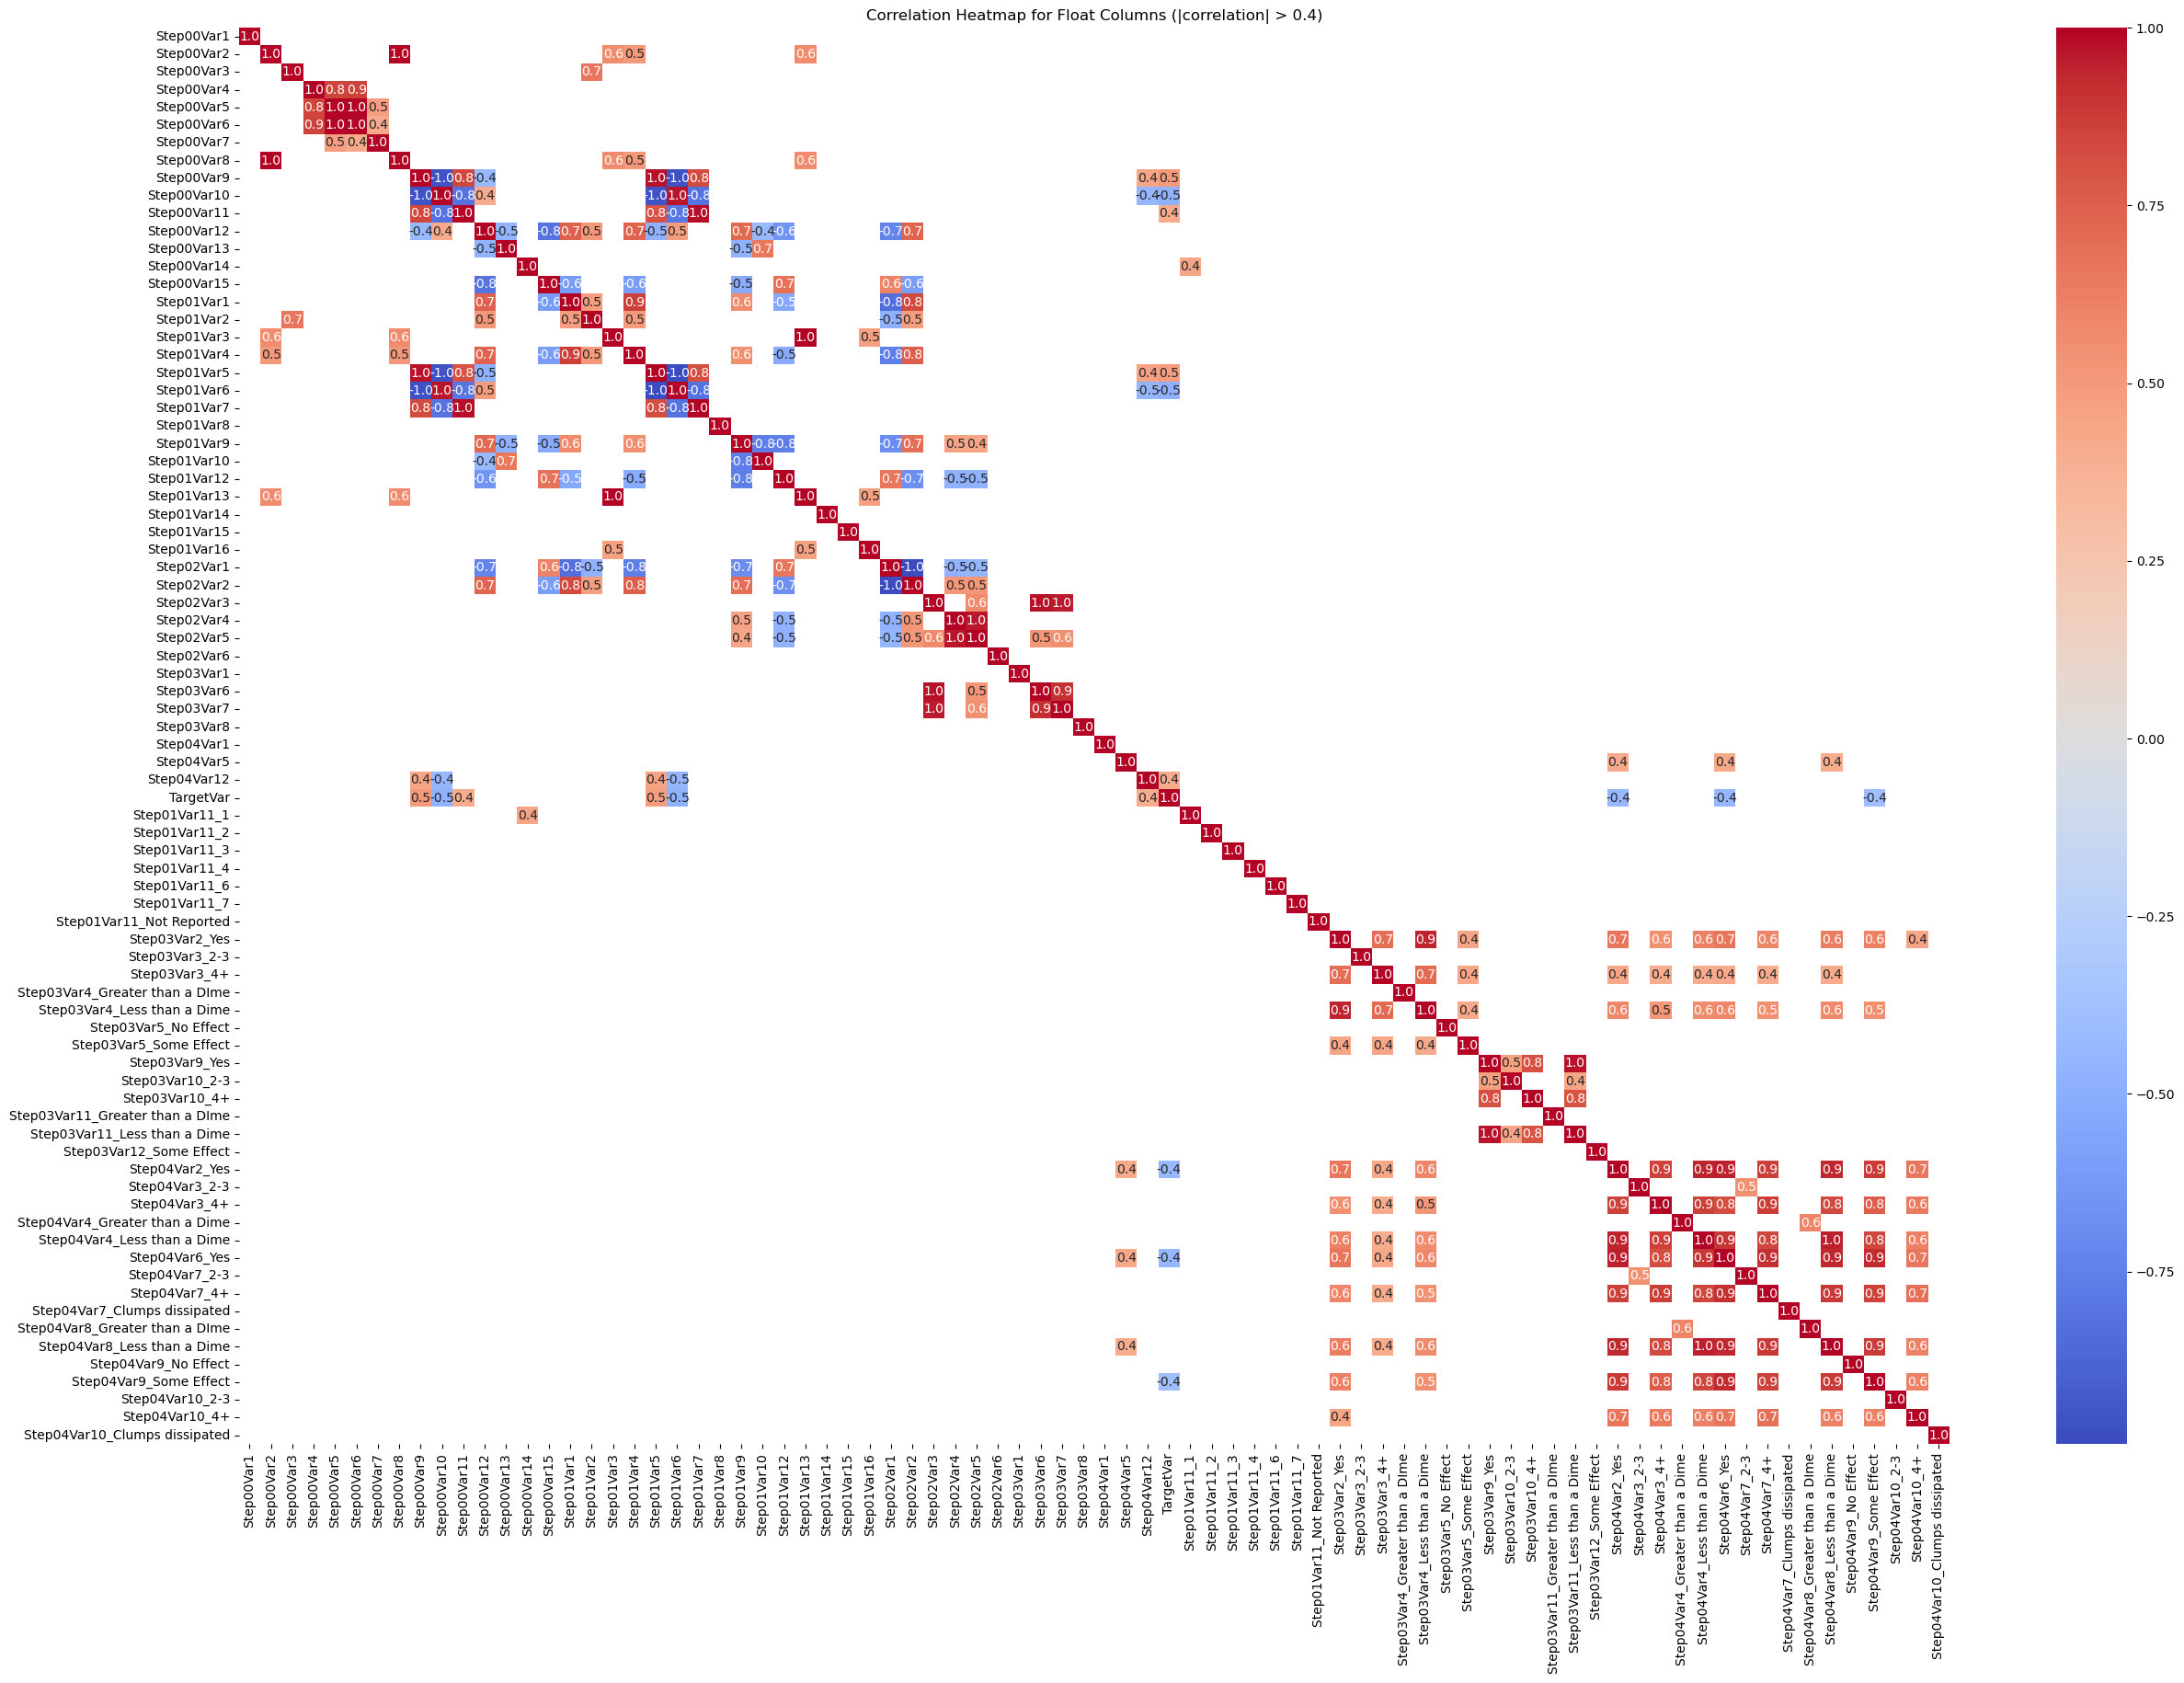

In [41]:
# Compute the correlation matrix for floating-point columns
correlation_matrix_floats = df[final_imputed_data.columns].corr()

# Filter the correlation matrix to show only correlations above a certain threshold
threshold = 0.4
correlation_matrix_filtered_floats = correlation_matrix_floats.copy()
correlation_matrix_filtered_floats[(correlation_matrix_floats.abs() < threshold)] = np.nan

# Plot the heatmap with the filtered correlation matrix for float columns
plt.figure(figsize=(30, 20))
sns.heatmap(correlation_matrix_filtered_floats, annot=True, fmt=".1f", cmap="coolwarm", mask=correlation_matrix_filtered_floats.isnull())
plt.title(f"Correlation Heatmap for Float Columns (|correlation| > {threshold})")
plt.show()

In [42]:
# Extract pairs of highly correlated variables
high_corr_pairs = correlation_matrix_floats.unstack().reset_index()
high_corr_pairs.columns = ['Variable1', 'Variable2', 'Correlation']

# Filter out self-correlations and correlations below the threshold
high_corr_pairs = high_corr_pairs[(high_corr_pairs['Variable1'] != high_corr_pairs['Variable2']) & 
                                  (abs(high_corr_pairs['Correlation']) > 0.90)]

# Sort by absolute correlation value
high_corr_pairs = high_corr_pairs.sort_values(by='Variable1', ascending=True)
high_corr_pairs

,Variable1,Variable2,Correlation
740,Step00Var10,Step01Var6,0.964352
739,Step00Var10,Step01Var5,-0.954608
728,Step00Var10,Step00Var9,-0.958809
821,Step00Var11,Step01Var7,0.978925
87,Step00Var2,Step00Var8,0.994577
325,Step00Var5,Step00Var6,1.000000
404,Step00Var6,Step00Var5,1.000000
561,Step00Var8,Step00Var2,0.994577
659,Step00Var9,Step01Var5,0.969221
660,Step00Var9,Step01Var6,-0.965822


## Visualization of Outlier Distribution before and after imputation

### The orginal boxplots of numerical values and violin plots with standardization

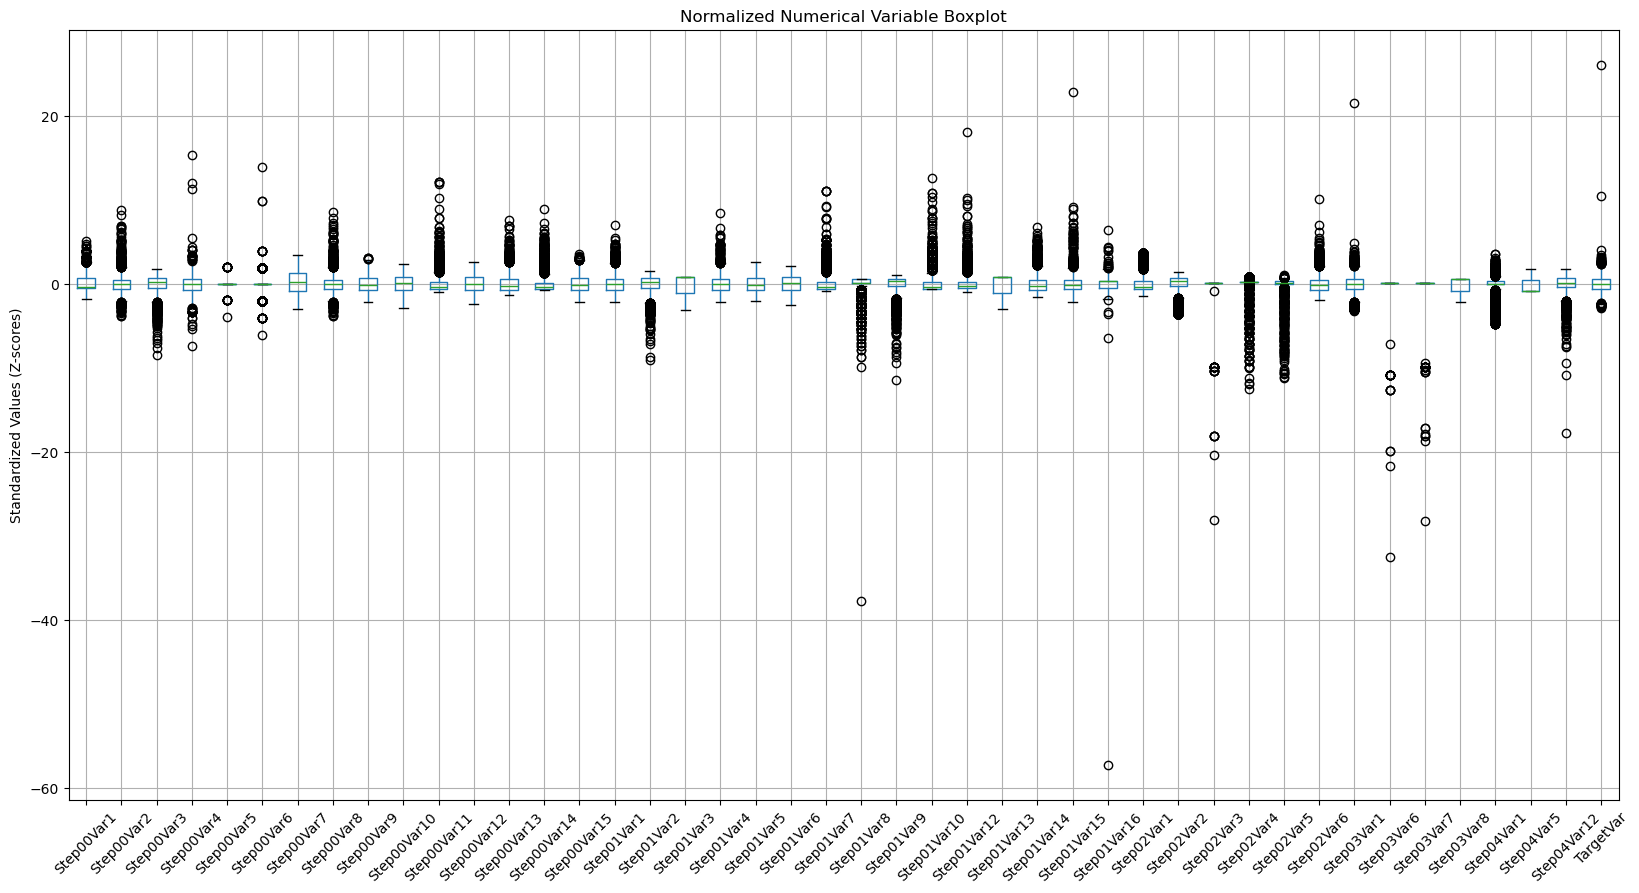

In [56]:
import pandas as pd
scaler = StandardScaler()
num_vars_normal = pd.DataFrame(
    scaler.fit_transform(num_vars), 
    columns=num_vars.columns
)
plt.figure(figsize=(20, 10))
num_vars_normal.boxplot()
plt.title('Normalized Numerical Variable Boxplot')
plt.xticks(rotation=45)
plt.ylabel('Standardized Values (Z-scores)')
plt.show()

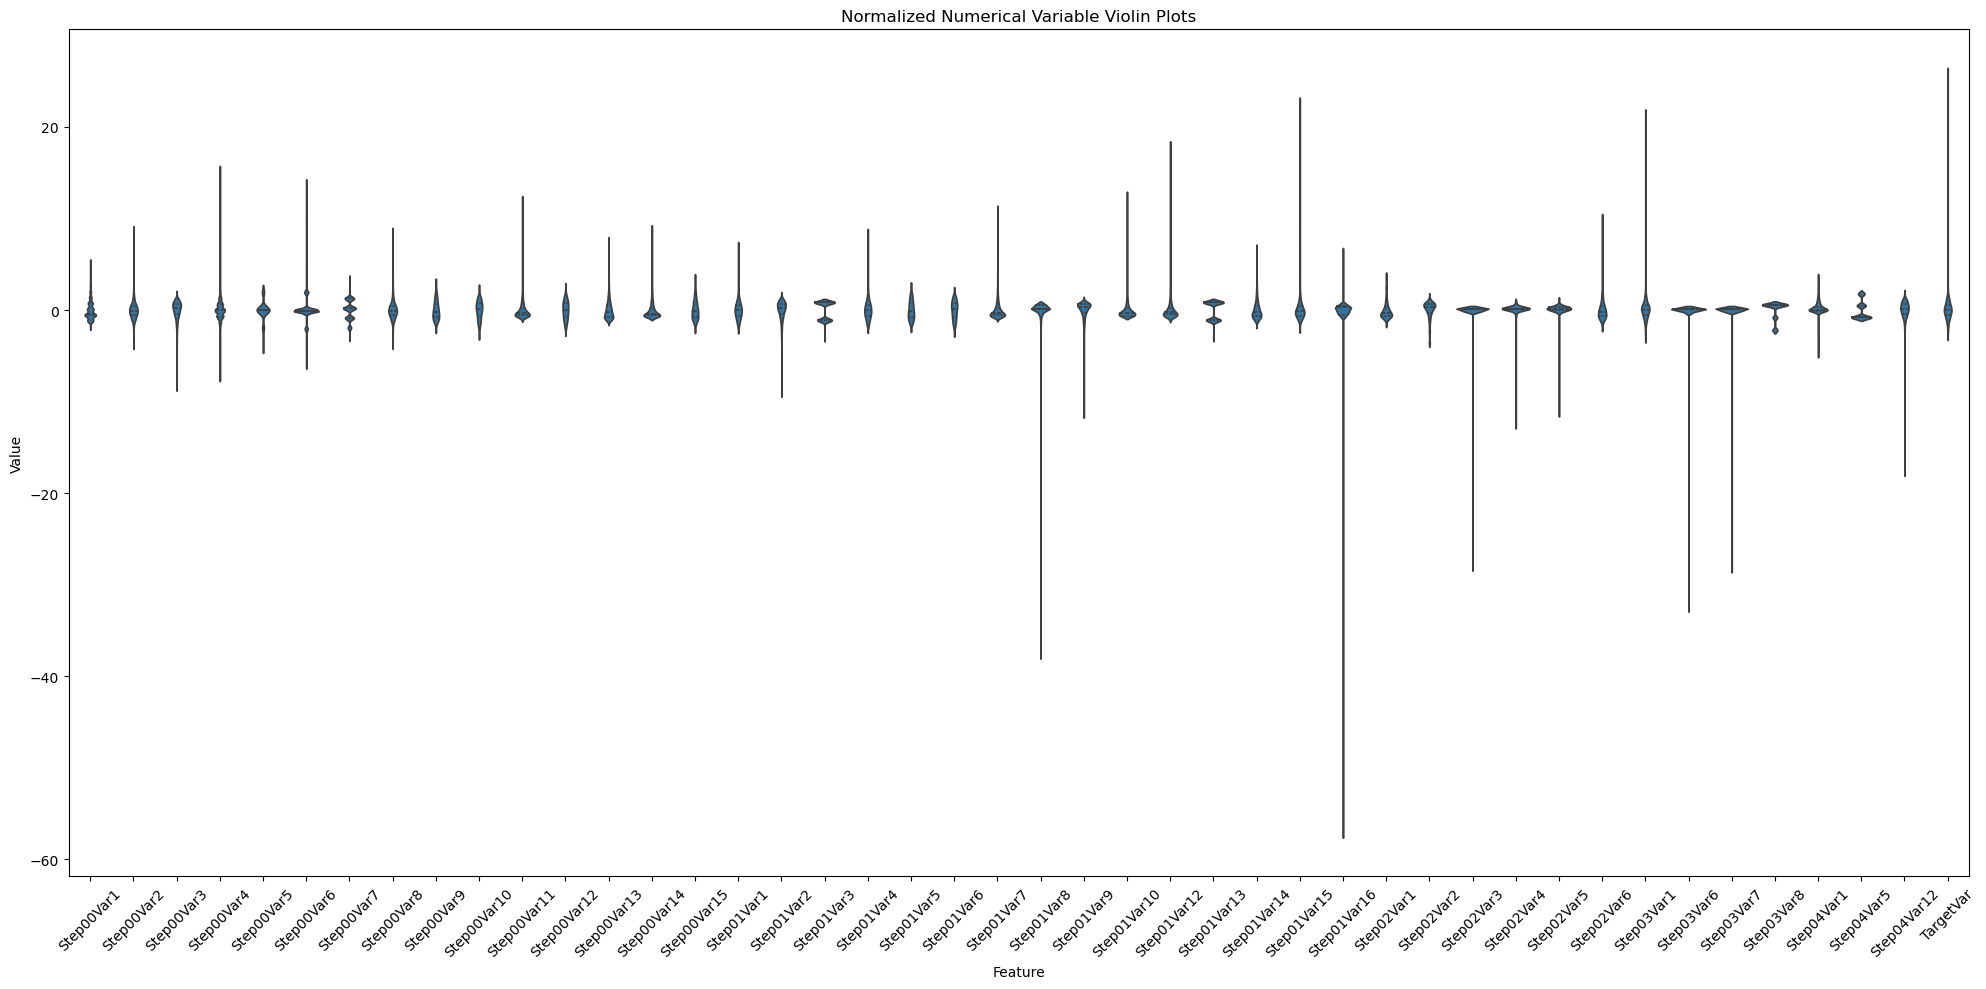

In [65]:
import seaborn as sns
# Convert data to long format for violin plot
long_df = num_vars_normal.melt(var_name='Feature', value_name='Value')

plt.figure(figsize=(20, 10))
sns.violinplot(x='Feature', y='Value', data=long_df, inner='quartile')
plt.title('Normalized Numerical Variable Violin Plots')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### The boxplots and violin plots after imputation

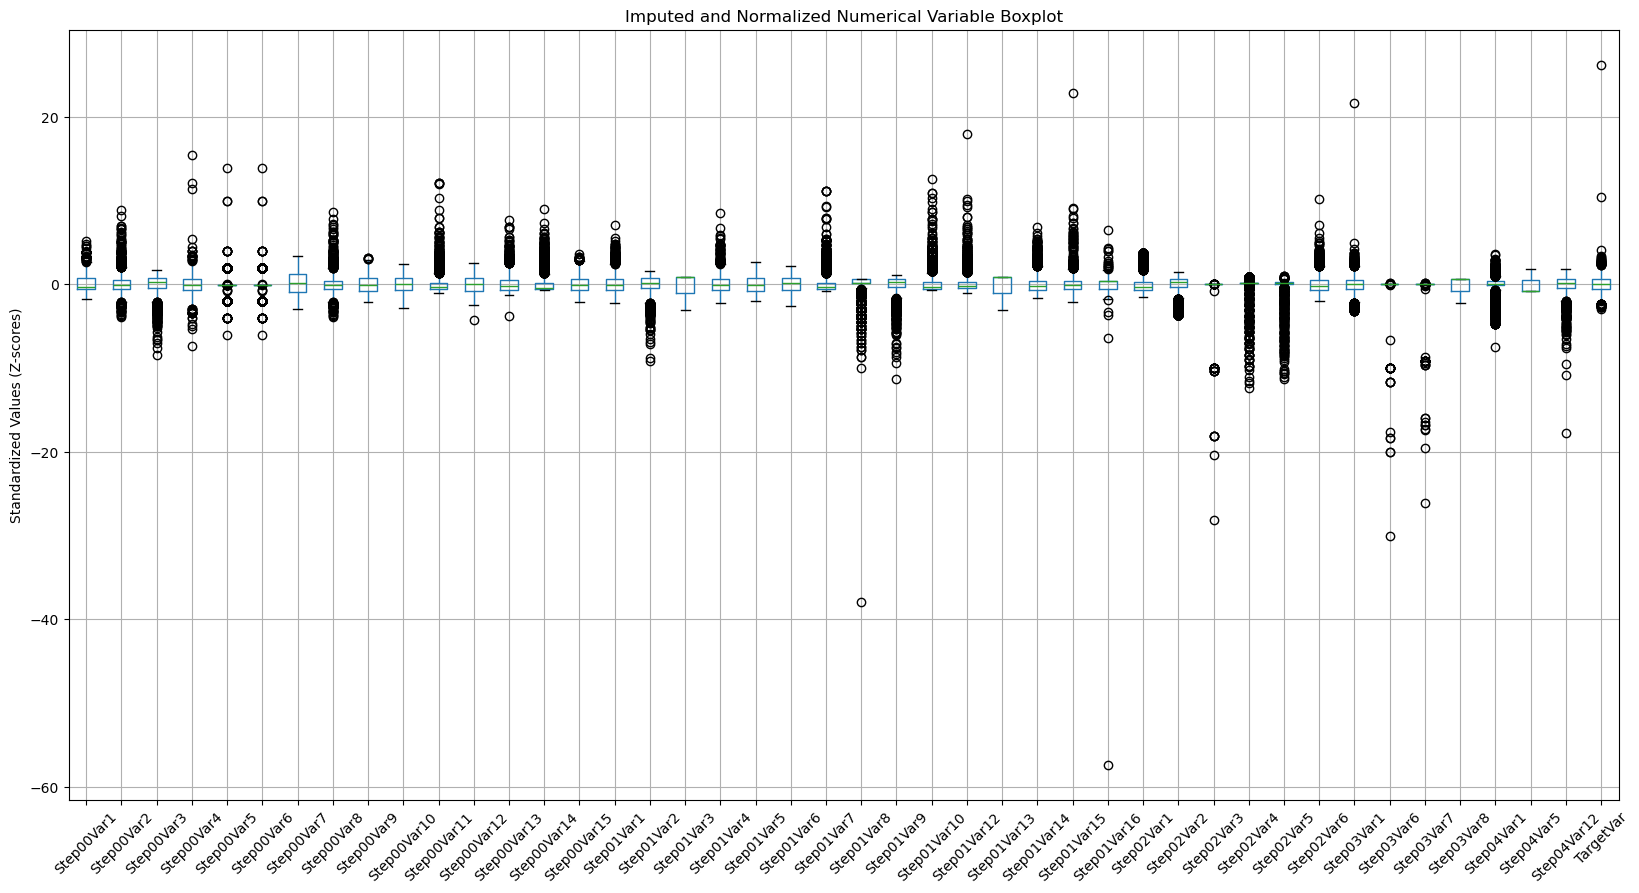

In [58]:
import pandas as pd
imputed_num_vars = final_imputed_data.select_dtypes(include=[np.float64])
scaler = StandardScaler()
imputed_num_vars_normal = pd.DataFrame(
    scaler.fit_transform(imputed_num_vars), 
    columns=imputed_num_vars.columns
)
# Combine all variables into a single boxplot
plt.figure(figsize=(20, 10))
imputed_num_vars_normal.boxplot()
plt.title('Imputed and Normalized Numerical Variable Boxplot')
plt.xticks(rotation=45)
plt.ylabel('Standardized Values (Z-scores)')
plt.show()

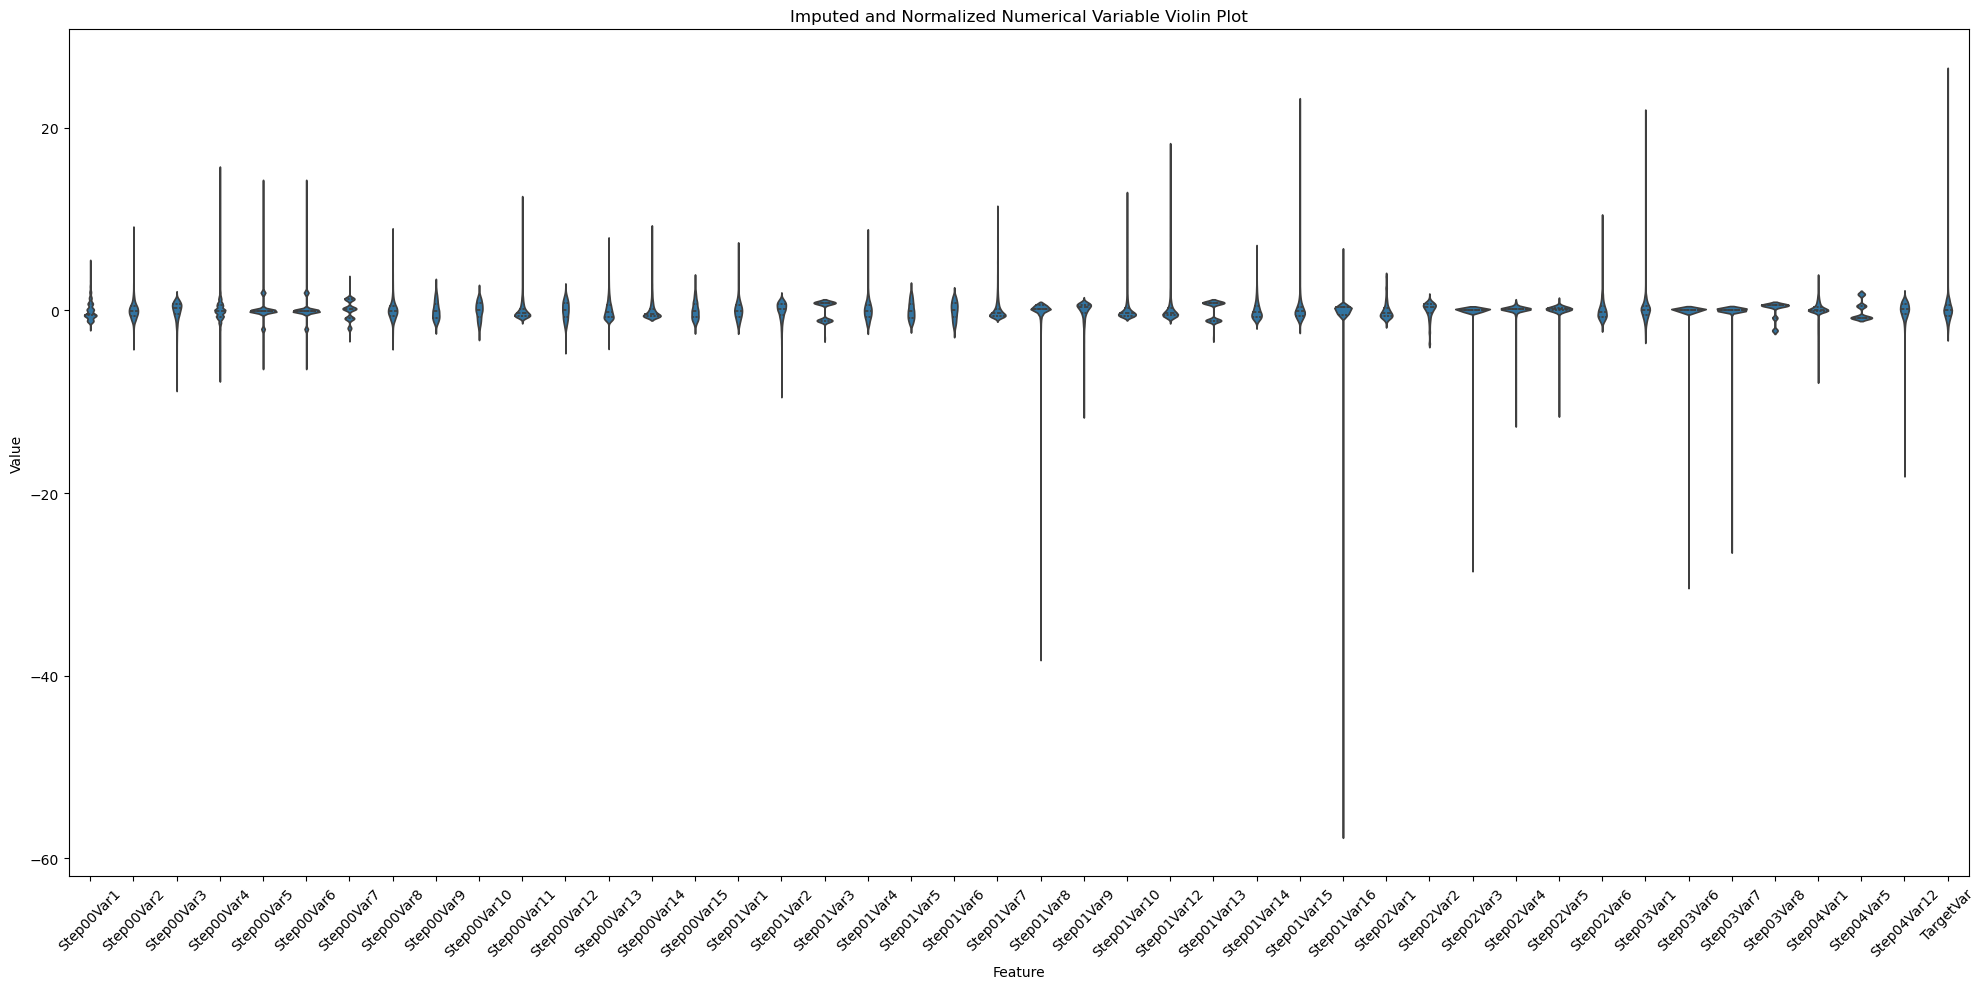

In [64]:
import seaborn as sns
# Convert data to long format for violin plot
long_df = imputed_num_vars_normal.melt(var_name='Feature', value_name='Value')

plt.figure(figsize=(20, 10))
sns.violinplot(x='Feature', y='Value', data=long_df, inner='quartile')
plt.title('Imputed and Normalized Numerical Variable Violin Plot')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Outlier Detection

calculate percent of different categorical values; lower than a threshold -> outlier   
compare the outlier overlap   
remove the outliers, and use mice try

### Now the outlier method will clip the anomalies out of the [0.05, 0.95] range into the lower and upper bound, without dropping any columns.  
- Check if the method is okay, if it is better to remove outliers/ transform outliers?
- Check if we impute and then conduct outlier detection, or remove outliers in the first place?

In [66]:
# Use Isolation Forest to deal with the outlier
from sklearn.ensemble import IsolationForest
import numpy as np
# Initialize Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
# Fit the model and predict anomalies
final_imputed_data['anomaly'] = iso_forest.fit_predict(final_imputed_data)
# Anomalies are labeled as -1
anomalies = final_imputed_data[final_imputed_data['anomaly'] == -1]
for col in final_imputed_data.columns:
    upper_limit = final_imputed_data[col].quantile(0.95)
    lower_limit = final_imputed_data[col].quantile(0.05)
    final_imputed_data[col] = np.clip(final_imputed_data[col], lower_limit, upper_limit)

## Post outlier treatment visualization

Step02Var3 and Step03Var8 still has extreme outliers

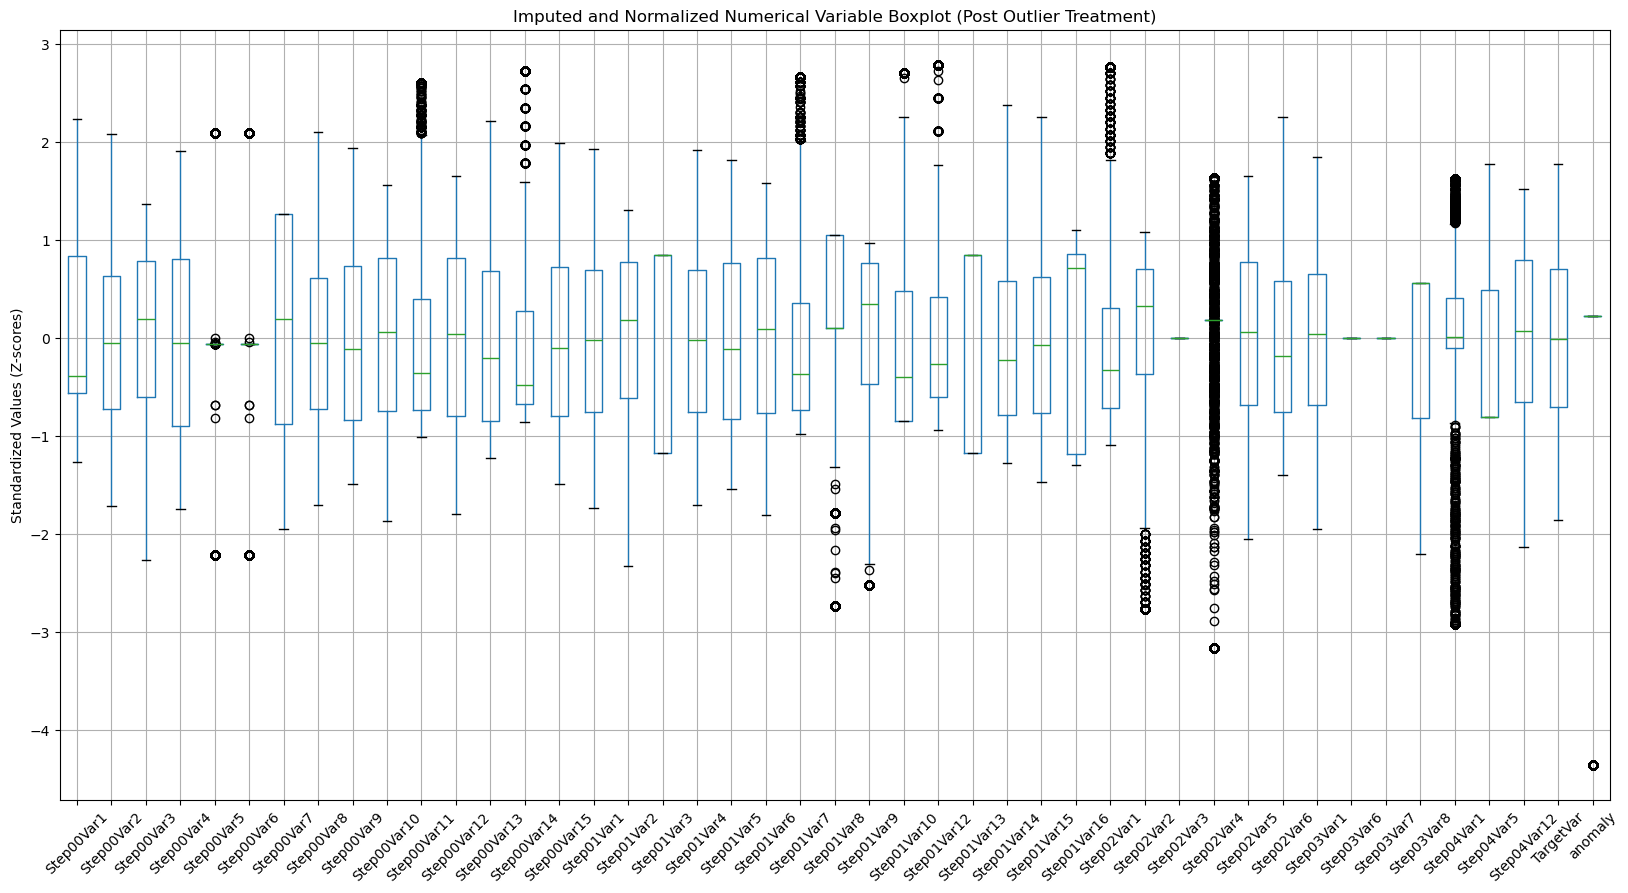

In [69]:
plt.figure(figsize=(20, 10))
imputed_num_vars = final_imputed_data.select_dtypes(include=[np.float64])
scaler = StandardScaler()
imputed_num_vars_normal = pd.DataFrame(
    scaler.fit_transform(imputed_num_vars), 
    columns=imputed_num_vars.columns
)
imputed_num_vars_normal.boxplot()
plt.title('Imputed and Normalized Numerical Variable Boxplot (Post Outlier Treatment)')
plt.xticks(rotation=45)
plt.ylabel('Standardized Values (Z-scores)')
plt.show()

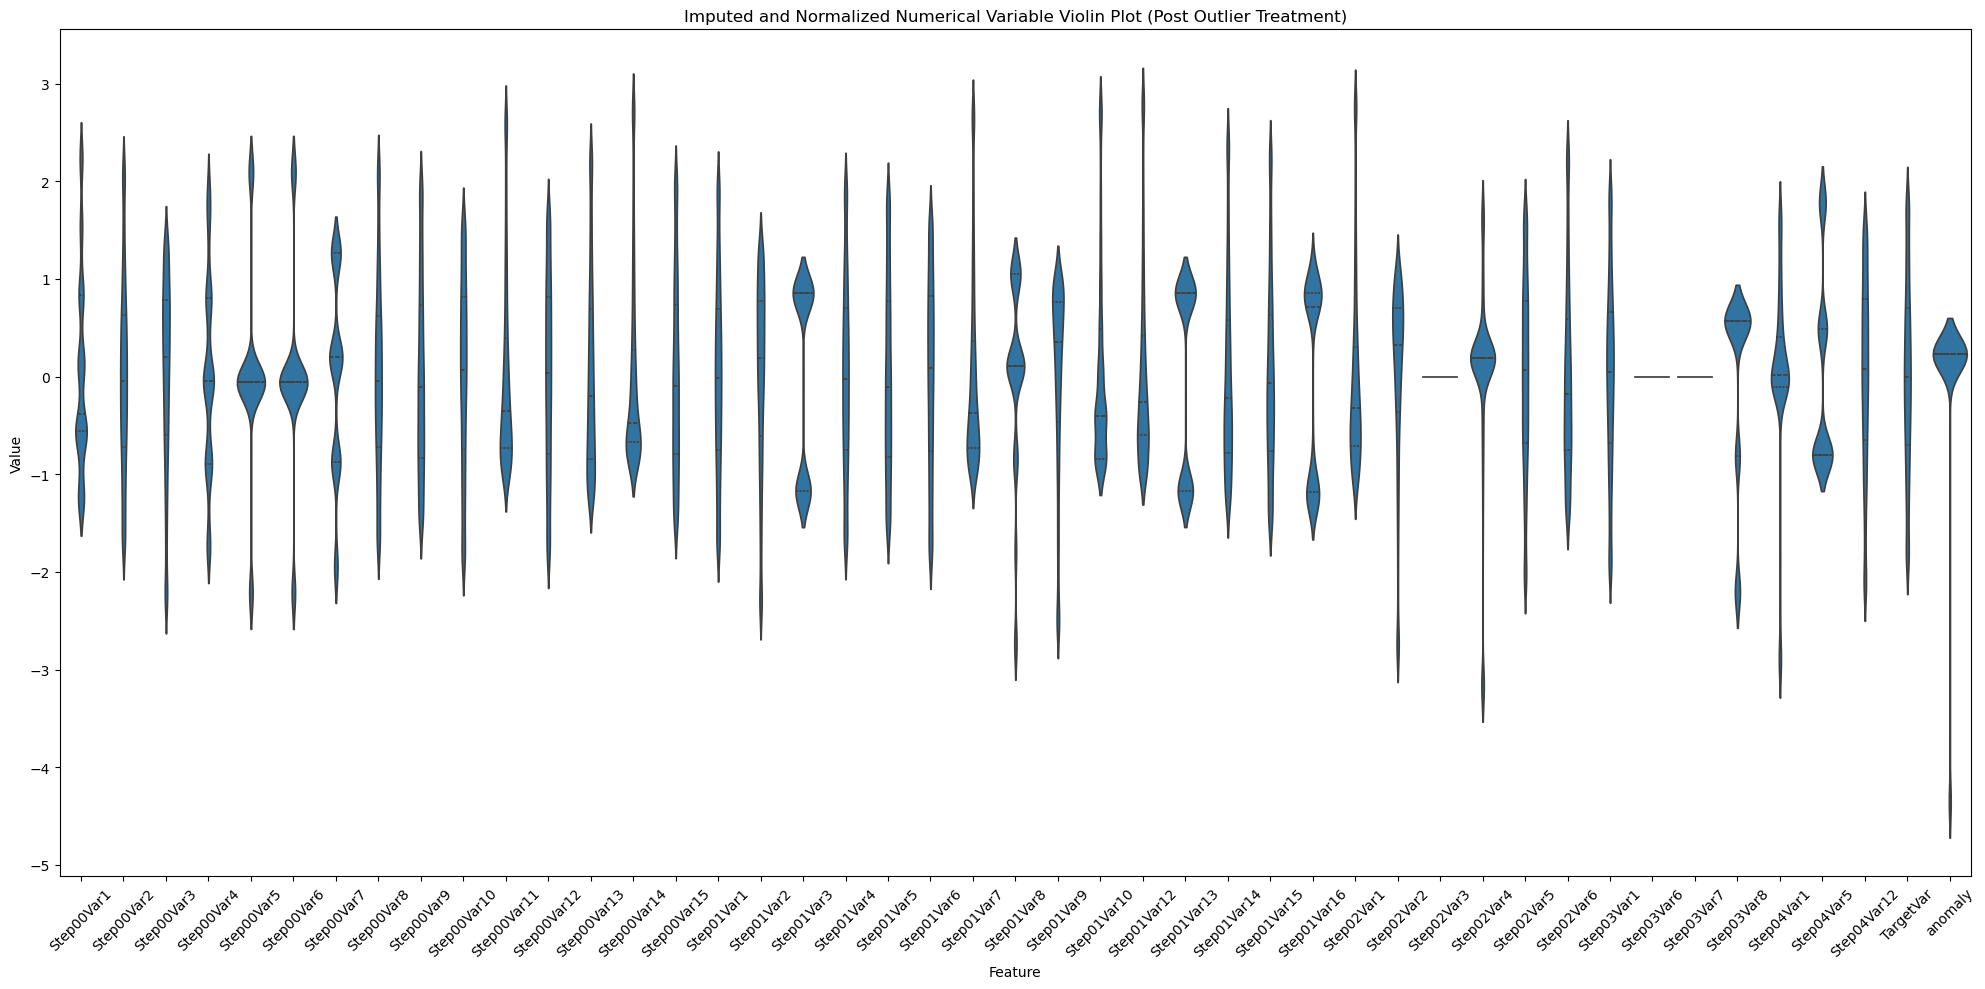

In [71]:
long_df = imputed_num_vars_normal.melt(var_name='Feature', value_name='Value')
plt.figure(figsize=(20, 10))
sns.violinplot(x='Feature', y='Value', data=long_df, inner='quartile')
plt.title('Imputed and Normalized Numerical Variable Violin Plot (Post Outlier Treatment)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()